<a href="https://colab.research.google.com/github/jaimegonzalezc/KC-LLMs/blob/main/practica-LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chatbot especializado guitarras eléctricas y acústicas

En esta práctica del módulo de Large Language Models del Bootcamp de Full Stack AI se nos pide hacer uso de un modelo de lenguaje open source y personalizarlo para realizar una tarea concreta.

En mi caso, he pensado varias opciones hasta que me decanté por una final, no sin antes proabr la viabilidad de todas en cuanto a recursos técnicos y tiempos de entrega, siendo:
* En primer lugar pensé en crear un agente para aprender a tocar la guitarra desde cero, actuando como un profesor online que pusiera deberes. Para ello, hice pruebas para descargar via API cientos de tablaturas de canciones de https://www.ultimate-guitar.com/ ya que pensé que al ser texto plano podría ser bueno poniendo ejercicios para principiantes. No fue tan bueno, de hecho ninguno de los grandes LLMs públicos son muy buenos a día de hoy haciendo esto,por lo que descarté esta opción.
* Otra opción fue hacer un agente "analista de ciberseguridad" ampliando las bases de conocimiento del modelo con múltiples documentos sobre normativas y buenas prácticas de seguridad via RAG. Estuve investigando y creo que sería bastante complicado hacerlo por código y descubrí que existen aplicaciones que te ayudan a generar tu propio agente sin código como N8N y uso de bases de datos vectoriales como Milvus o Qdrant. Por ello, esta opción se desestimó aunque no descarto montar un agente así que podría ayudarme en mi día a día y de hecho podría ser un gran trabajo de fin de bootcamp.
* Por último, pensé en especializar un modelo para que sepa mucho sobre guitarras eléctricas. Bicheando por Kaggle llegué a este Dataset https://www.kaggle.com/datasets/thebumpkin/small-guitar-model-dataset-113-models que consideré buien punto de partida para especializar mi modelo con un fine-tuning. Por ello, amplié la información añadiendo los géneros más comunes que se tocan con cada modelo de guitarra, con el objetivo que a parte de saber de las especificaciones técnicas de las guitarras, conozca en qué géneros se usan y así poder solicitar ayuda para elegir una marca y modelod e guitarra que se adapte al usuario.

Por tanto, ya que este último es el proyecto elegido, paso a detallar el alcance y los objetivos:
- Hablar y entender sobre modelos de guitarras y sus características
- Recomendar marcas y modelos basado en las preferencias del usuario
- Hablar sobre guitarristas famosos que usen ciertas guitarras
- Conocer la historia de las guitarras y año de fabricación

Por ello, lo primero fue ampliar la información del csv ampliando la columna Subgenres utilizando para ello el nuevo chatbot de deepseek.

Instalamos paquetes necesarios, importamos y montamos almacenamiento en Drive:


In [1]:
!pip install torch transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
from datasets import Dataset
from transformers import TrainingArguments, Trainer, AutoModelForCausalLM, AutoTokenizer, pipeline
from peft import LoraConfig, get_peft_model
import torch
from huggingface_hub import login

Ya podemos visualizar nuestro dataset vitaminado almacenado en Drive. Podemos ver información como:
* Marca
* Modelo
* Fecha en introducción en el mercado
* Grandes personajes que han usado esos modelos
* Las principales características dle modelo
* La popularidad
* Los periodos de tiempo en los que se han fabricado
* Los acabados disponibles
* Lo subgéneros que hemos añadido

In [6]:
df = pd.read_csv("/content/drive/MyDrive/Bootcamp IA/LLMs/GuitarModelsCustom.csv")
df.head(10)

,Maker,Model,Introduced,NotableUser1,NotableUser2,NotableUser3,Feature1,Feature2,Feature3,Feature4,Feature5,Popularity,Dates,Finish1,Finish2,Finish3,Finish4,Finish5,Subgenres
0,Fender,Bronco,1967,Johnny Winter,NaN,NaN,Short scale length (24 inches),Single pickup,Unique tremolo system,Offset body design,NaN,Designed as a student model but has been used ...,"1967 - 1981, 1994 - 2001, 2011 - 2021",Fiesta Red,Sonic Blue,Dakota Red,NaN,NaN,Blues; Rock
1,Fender,Bullet,1981,NaN,NaN,NaN,Designed as an affordable entry-level guitar,Single or dual single-coil pickups,Stratocaster-style body,Hardtail or tremolo bridge,NaN,"Aimed at students and beginners, known for its...","1981 - 1983, 2007 - 2010",Arctic White,Fiesta Red,Black,NaN,NaN,Rock; Pop; Indie
2,Fender,Coronado,1965,Elvis Presley,Dave Davies,NaN,Fully hollow body,DeArmond single-coil pickups,Bolt-on neck,Floating bridge with a trapeze tailpiece,NaN,A departure from Fender's solid-body tradition...,"1966 - 1972, 2013 - 2017",Antigua,Cherry Red,Wildwood I,NaN,NaN,Rockabilly; Blues; Jazz
3,Fender,Cyclone,1997,NaN,NaN,NaN,"Mix of Stratocaster, Mustang, and Jaguar features",Humbucker in the bridge and single-coil in the...,Short scale length (24.75 inches),Offset body design,NaN,Versatile guitar popular among alternative roc...,1997 - 2012,Candy Apple Red,Sonic Blue,Lake Placid Blue,NaN,NaN,Alternative; Rock
4,Fender,Duo-Sonic,1956,Jimi Hendrix,Rory Gallagher,NaN,Short scale length (22.5 or 24 inches),Two single-coil pickups,"Simple, straightforward design",Offset body design,NaN,Initially targeted at student guitarists but l...,"1956 - 1969, 1993 - 1999, 2016 - Present",Arctic White,Capri Orange,Torino Red,Desert Sand,NaN,Rock; Blues; Indie
5,Fender,Esquire,1950,Bruce Springsteen,Jeff Beck,NaN,Single pickup,Similar body to the Telecaster,Bolt-on neck,String-through-body design,NaN,Known for its simplicity and bright tone.,"1950 - 1969, 1986 - Present",Butterscotch Blonde,Black,White Blonde,NaN,NaN,Rock; Blues; Country
6,Fender,Jaguar,1962,Kurt Cobain,Johnny Marr,NaN,Shorter scale length (24 inches),Dual circuit design similar to the Jazzmaster,Unique switching system with on/off and high-p...,Floating tremolo system,NaN,Became popular with surf rock musicians and la...,1962 - Present,Sunburst,Candy Apple Red,Olympic White,Surf Green,NaN,Surf Rock; Alternative; Indie
7,Fender,Jazz Bass (J-Bass),1960,Jaco Pastorius,Geddy Lee,Marcus Miller,Dual single-coil pickups,Offset body design similar to the Jazzmaster,Narrower neck at the nut compared to the P-Bass,NaN,NaN,"Known for its versatility and bright, punchy t...",1960 - Present,Sunburst,Olympic White,Black,Natural,NaN,Jazz; Funk; Rock
8,Fender,Jazzmaster,1958,Tom Verlaine,J Mascis,Kevin Shields,Offset body design for better balance when seated,Dual circuit design with separate rhythm and l...,"Wide, flat single-coil pickups",Floating tremolo system,NaN,Initially targeted at jazz musicians but gaine...,1958 - Present,Sunburst,Olympic White,Surf Green,Candy Apple Red,NaN,Jazz; Surf Rock; Alternative; Indie
9,Fender,Katana,1985,NaN,NaN,NaN,Radical body shape inspired by Japanese katana...,Single humbucking pickup,Set neck,Minimalist controls,NaN,"Aimed at metal and hard rock players, known fo...",1985 - 1986,Various finishes including Sunburst,Black,Olympic White,NaN,NaN,Metal; Hard Rock


Visto el dataset, vamos a empezar bajando el modelo de Hugging Face, para ello nos autenticamos con nuestro Access Token, descargamos el modelo y cargamos el modelo y el tokenizer:

In [8]:
login("") # Access Token de HF, eliminado por seguridad

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


LocalTokenNotFoundError: Token is required (`token=True`), but no token found. You need to provide a token or be logged in to Hugging Face with `huggingface-cli login` or `huggingface_hub.login`. See https://huggingface.co/settings/tokens.

In [9]:
# Nombre del modelo en Hugging Face
model_name = "NousResearch/Llama-3.2-1B"

# Cargar el tokenizador y el modelo
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/186 [00:00<?, ?B/s]

Se ha escogido el modelo NousResearch/Llama-3.2-1B, ya que lo hemos visto en clase y conozco que da buenos resultados. Además, quería utilizar el modelo llama y este esa bastante ligero para pode rtrabajar cómodamente.

Una vez cargado el modelo, vamos a crear una función para lanzar un prompt al modelo y recibir la respuesta:

In [ ]:
# Función para generar texto
def generate_prompt(prompt, max_length=200, temperature=0.7):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")  # Pasar a GPU si está disponible
    output = model.generate(
        inputs["input_ids"],
        max_length=max_length,
        temperature=temperature,
        do_sample=True
    )
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Prueba el modelo con un prompt
prompt = "Which is the best Gibson guitar model for hard rock?"
response = generate_prompt(prompt)
print(response)

Tuve un problema cone l entorno de ejecución ya que acabé con la GPU gratuita de Google Collab y al ejecutar de nuevo la celda fallaba al estar esperando una artquitectura CUDA. Pero he podido rescatar la respuesta de una versión del fichero anterior:

```
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Which is the best Gibson guitar model for hard rock? What should I look for in a Gibson guitar? This video will help you find the answer.
The Gibson Les Paul is the quintessential hard rock guitar. It’s versatile, has a big sound, and is a great player’s guitar. But which model of the Les Paul is the best for hard rock?
The most popular Gibson Les Paul model for hard rock is the Les Paul Custom. This model is made with an alder body, a maple neck, and a 2-piece maple top. This model has a gold-finished neck, gold hardware, and a gold-finished tuning machine head. The Les Paul Custom has a 24.75-inch scale length, a 19-fret neck, and a 22-fret body. The Les Paul Custom is a great player’s guitar with a big sound and excellent tone.
If you’re looking for a Gibson Les Paul model that can handle the rigors of hard rock,
```

El modelo responde bastante bien, pero no incluye toda la información que hemos seleccionado en el dataset y nos da una respuesta bastante genérica.

Por tanto, empezamos con el Fine Tuning. Para ello, lo primero es definir un prompt de sistema que va a permitir guiar al modelo en su comportamiento durante la interacción, definiendo el tipo de respuestas que se esperan.

Es importante remarcar que finalmente se ha realizado la práctica en inglés, ya que se obtienen mucho mejores resultados. En español encontré bastantes problemas de alucinaciones y repeticiones.

In [ ]:
def create_prompt(row):
    prompt = f"Tell me about the {row['Maker']} {row['Model']}."
    response = f"The {row['Maker']} {row['Model']} was introduced in {row['Introduced']}. "

    notable_users = [row[user] for user in ["NotableUser1", "NotableUser2", "NotableUser3"] if pd.notna(row[user])]
    if notable_users:
        response += f"Some musicians who have used it include {', '.join(notable_users)}. "

    features = [row[feature] for feature in ["Feature1", "Feature2", "Feature3", "Feature4", "Feature5"] if pd.notna(row[feature])]
    if features:
        response += f"Its features include {', '.join(features)}. "

    response += f"It was popular between {row['Dates']} and is used in the {row['Subgenres']} genres."

    return {"text": f"{prompt}\n{response}"}

formatted_data = df.apply(create_prompt, axis=1)
dataset = Dataset.from_pandas(pd.DataFrame(formatted_data.tolist()))

dataset = dataset.train_test_split(test_size=0.1) # Train test split con 90% para train


Aplicamos el prompt a nuestro dataset y configuramos LoRA para realizar el Fine Tunning:


In [ ]:

# Configurar LoRA (Fine-Tuning eficiente)
lora_config = LoraConfig(
    r=8, lora_alpha=32, lora_dropout=0.05, bias="none", task_type="CAUSAL_LM"
)
model = get_peft_model(model, lora_config)
tokenizer.pad_token = tokenizer.eos_token


# Tokenización de los datos
def tokenize_function(examples):
    tokens = tokenizer(examples["text"], padding=True, truncation=True, max_length=512)
    tokens["labels"] = tokens["input_ids"].copy()  # Agregar etiquetas para calcular la pérdida
    return tokens

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Configuración del entrenamiento
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Bootcamp IA/LLMs/guitar_llama",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=10,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    report_to="none",
    save_total_limit=1,
    fp16=True,
)

# Entrenamiento del modelo con el nuevo tokenizer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
)
trainer.train()

model.save_pretrained("/content/drive/MyDrive/Bootcamp IA/LLMs/guitar_llama_model", safe_serialization=True)
tokenizer.save_pretrained("/content/drive/MyDrive/Bootcamp IA/LLMs/guitar_llama_model")

Map:   0%|          | 0/101 [00:00<?, ? examples/s]

Map:   0%|          | 0/12 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-29657b182d16>:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.944100,2.002110
2,1.266600,1.342861
3,1.110300,1.118769


('/content/drive/MyDrive/Bootcamp IA/LLMs/guitar_llama_model/tokenizer_config.json',
 '/content/drive/MyDrive/Bootcamp IA/LLMs/guitar_llama_model/special_tokens_map.json',
 '/content/drive/MyDrive/Bootcamp IA/LLMs/guitar_llama_model/tokenizer.json')

Se ha almacenado el modelo prentrenado en drive para no tener que reentrenarlo cada vez que cabio el entorno de ejección o me expira la sesión. De esta forma solo tengo cargar el modelo.

In [ ]:
# Cargar modelo entrenado
fine_tuned_model = AutoModelForCausalLM.from_pretrained("/content/drive/MyDrive/Bootcamp IA/LLMs/guitar_llama_model")
fine_tuned_tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Bootcamp IA/LLMs/guitar_llama_model")

# Crear pipeline de generación de texto
pipe = pipeline("text-generation", model=fine_tuned_model, tokenizer=fine_tuned_tokenizer)

Device set to use cuda:0


Una vez cargado el nuevo modelo fine-tuneado, probamos:

In [ ]:
prompt = "What colors are available for the Fender Stratocaster?"
response = pipe(
    prompt,
    max_length=100,
    do_sample=True,
    temperature=0.7,  # Mayor diversidad
    top_p=0.9,  # Filtro de núcleo
    repetition_penalty=1.5  # Penalización a repeticiones
)
print(response[0]['generated_text'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


What colors are available for the Fender Stratocaster? The color of a guitar is one aspect that people often consider when making purchasing decisions. However, what exactly makes up this hue and how does it affect its overall appearance?
The most common type found on guitars today can be categorized into two broad categories: natural wood finishes (such as mahogany) or metallic sheen with additional components added such as binding around fretboards.
Guitar players tend to choose between these options because they offer unique


Vemos que el fine tuning ha sido bueno, porque nos está dando iunformación que se ha incorporado con el CSV aplicando LoRA, pero está alucinando un poco, seguramente debido al prompt pre-establecido. Pero estoy bastante contento con el resultado. Vamos a probar otros prompts:

In [ ]:
prompt = "Tell me three good guitars for playing blues."
response = pipe(
    prompt,
    max_length=100,
    do_sample=True,
    temperature=0.7,  # Mayor diversidad
    top_p=0.9,  # Filtro de núcleo
    repetition_penalty=1.5  # Penalización a repeticiones
)
print(response[0]['generated_text'])

Tell me three good guitars for playing blues. I'm a beginner and would like to play it.
I don't know if there are any specific brands that you're looking at, but my top choices in terms of the genre (blues) include:
• Gibson Les Paul Standard
The list can be expanded by adding other popular genres such as rock or country; however these were originally intended more specifically towards guitarists who played primarily one style rather than several styles simultaneously!


Aquí responde bastante bien, y como guitarrista, la respuesta es bastante acertada. Pero después ha seguido la conversación, como si se le hubiera preguntado qué guitarristas de blues le gustan. En la siguiente pregunta, voy a ampliar mucho la longitud máxima del prompt para ver hasta dónde puede llegar, también he bajado un poco la temperatura para mayor precisión:

In [ ]:
prompt = "I want to know the three best guitarists who use a Fender Stratocaster, and then tell me which guitar Kurt Cobain used."
response = pipe(
    prompt,
    max_length=1000,
    do_sample=True,
    temperature=0.5,  # Mayor diversidad
    top_p=0.9,  # Filtro de núcleo
    repetition_penalty=1.5  # Penalización a repeticiones
)
print(response[0]['generated_text'])

I want to know the three best guitarists who use a Fender Stratocaster, and then tell me which guitar Kurt Cobain used. I have heard of Jimi Hendrix but not really much about Eddie Van Halen or Angus Young.
The answer is: none! The only guitarist that uses an electric instrument with more than one pickup (the humbucker) was Steve Vai; he has been using this type since 1982 when his first album came out called "Viega".
KurtCobainsGuitar
What are some good songs by Nirvana?
How did George Harrison get famous?


La respuesta no es del todo mala a pesar de haber ampliado mucho la longitud de la respuesta. Seguramente se deba a que también he bajado la temperatura para buscar un mejor rendimiento.

Lo que no me termina de convencer es que la guitarra favorita de Kurt Cobain fuera una Les Paul, principalmente porque su estilo era más Fender que Gibson y seguramente contase con alguna Les Paul, pero con diferencia su guitarra favorita era la Fender Jaguar.

Veo que si ha alucinado bastante en cuanto al puente Floyd Rose, ya que en ningún caso se ha mencionado este tipo de puentes y además ha hecho referencia a un enlace de Wikipedia mostrando ese tipo de puentes flotantes.

Supongo que se debe a que en la base de datos habrá algún modelo de guitarra de Kurt Cobain que tuviera un puente Floyd Rose y debido al prompt de sistema inicial, intente hablar de las características de esas guitarras.


## Publicación de chatbot a Streamlit

Una vez comprobada la eficacia del modelo, lo voy a publicar con StreamLit para tener un modelo similar a ChatGPT, en el que se puede interactuar con el chatbot.

Instalamos e importamos:

In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 111.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.6 MB/s eta 0:00:00


In [ ]:
!npm install localtunnel

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇
added 22 packages in 4s
⠇
⠇3 packages are looking for funding
⠇  run `npm fund` for details
⠇

El siguiente código nos va a permitir crear un túnel público gratuito para poder exponer nuestra aplicación en internet. Ya que desde collab no podemos trabajar en localhost.

Obtenemos la IP pública del extremo final del túnel donde se va a publicar mi aplicación, ya que el servicio nos lo solicita como contraseña una vez que tengamos un endpoint público:

In [ ]:
import urllib
print("Password/Enpoint IP for localtunnel is:",urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

Password/Enpoint IP for localtunnel is: 34.125.165.79


El siguiente código va a almacenarse en un archivo .py que será lo que ejecutemos en streamlit. Por ello, importamos de nuevo el modelo prentrenado y configuramos un chatbot para poder interactuar de forma más cómoda con mi modelo:

In [ ]:
%%writefile app.py
import streamlit as st
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# 📌 Cargar modelo entrenado
@st.cache_resource  # Cachear el modelo para mejorar el rendimiento
def load_model():
    fine_tuned_model = AutoModelForCausalLM.from_pretrained("/content/drive/MyDrive/Bootcamp IA/LLMs/guitar_llama_model")
    fine_tuned_tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Bootcamp IA/LLMs/guitar_llama_model")
    return pipeline("text-generation", model=fine_tuned_model, tokenizer=fine_tuned_tokenizer)

# Cargar el pipeline
pipe = load_model()

# 📌 Interfaz de Streamlit
st.title("🎸 Guitar Llama Chatbot")
st.write("Ask me about guitars!")

# Inicializar el historial de la conversación en session_state
if "conversation" not in st.session_state:
    st.session_state.conversation = []

# Entrada de texto
user_input = st.text_input("Input:")

if st.button("Reply"):
    if user_input:
        # Generar respuesta del chatbot
        response = pipe(user_input, max_length=1000, do_sample=True, temperature=0.5, top_p=0.9, repetition_penalty=1.5)
        bot_response = response[0]['generated_text']

        # Guardar la pregunta y respuesta en el historial
        st.session_state.conversation.append(("You", user_input))
        st.session_state.conversation.append(("Chatbot", bot_response))

# Mostrar el historial de la conversación
st.write("### Conversation History:")
for speaker, text in st.session_state.conversation:
    if speaker == "You":
        st.write(f"**{speaker}:** {text}")
    else:
        st.write(f"🛍️ **{speaker}:** {text}")
    st.write("---")

Overwriting app.py


In [12]:
!streamlit run app.py &>/content/logs.txt &
!npx localtunnel --port 8501

⠙⠹⠸⠼⠴⠦Need to install the following packages:
localtunnel@2.0.2
Ok to proceed? (y) ^C


Y accediendo a la URL que nos genera de forma gratuita e incluyendo la contraseña que hemos sacado anteriormente, llegamos a nuestra aplicación!

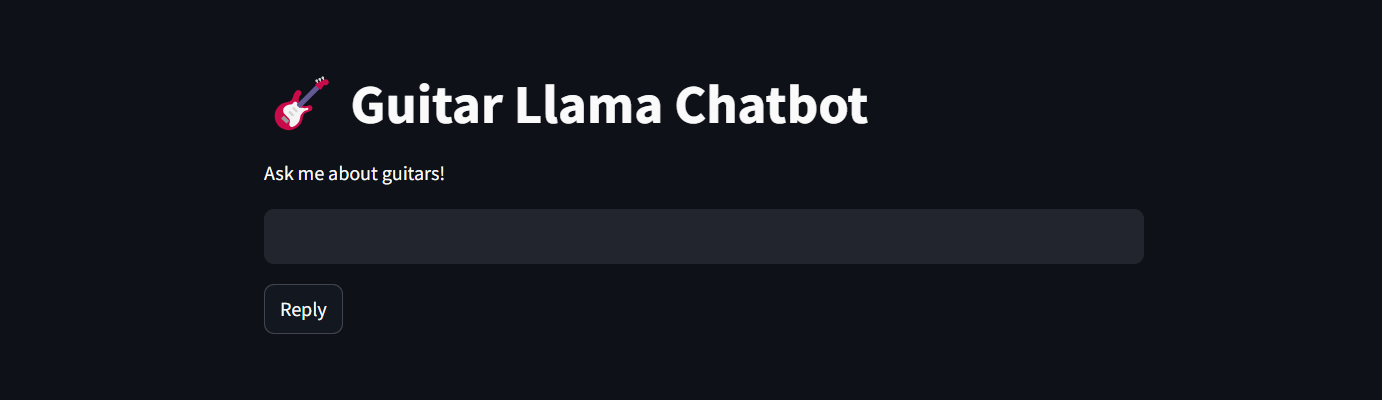

En esta primera imagen me di cuenta de que el modelo solo aceptaba una petición,por lo que tuve que modificar el código para poder almacenar el histórico de la conversación y obtener nuevos resultados:

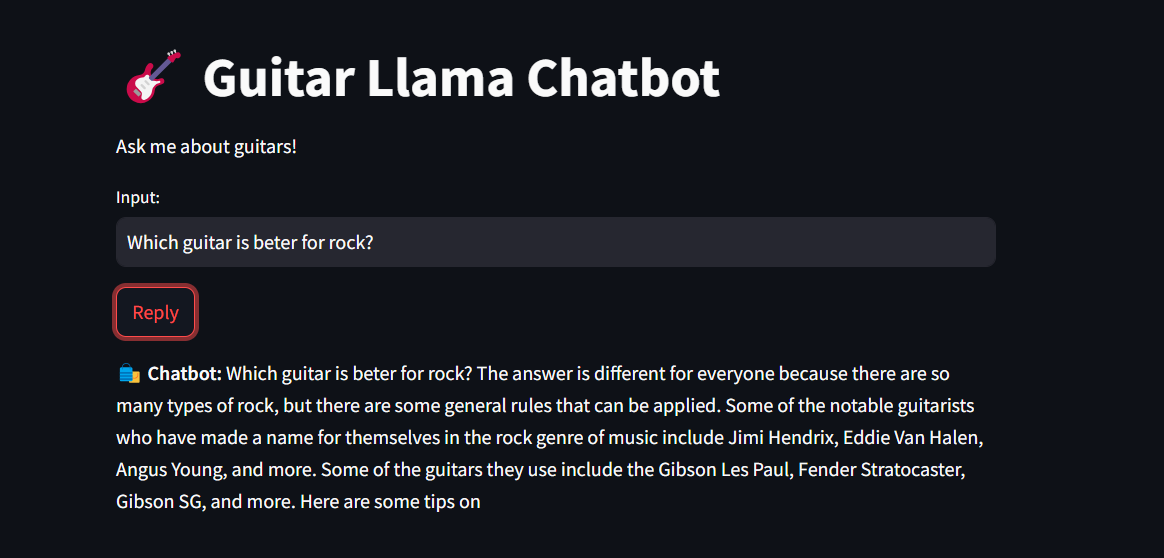

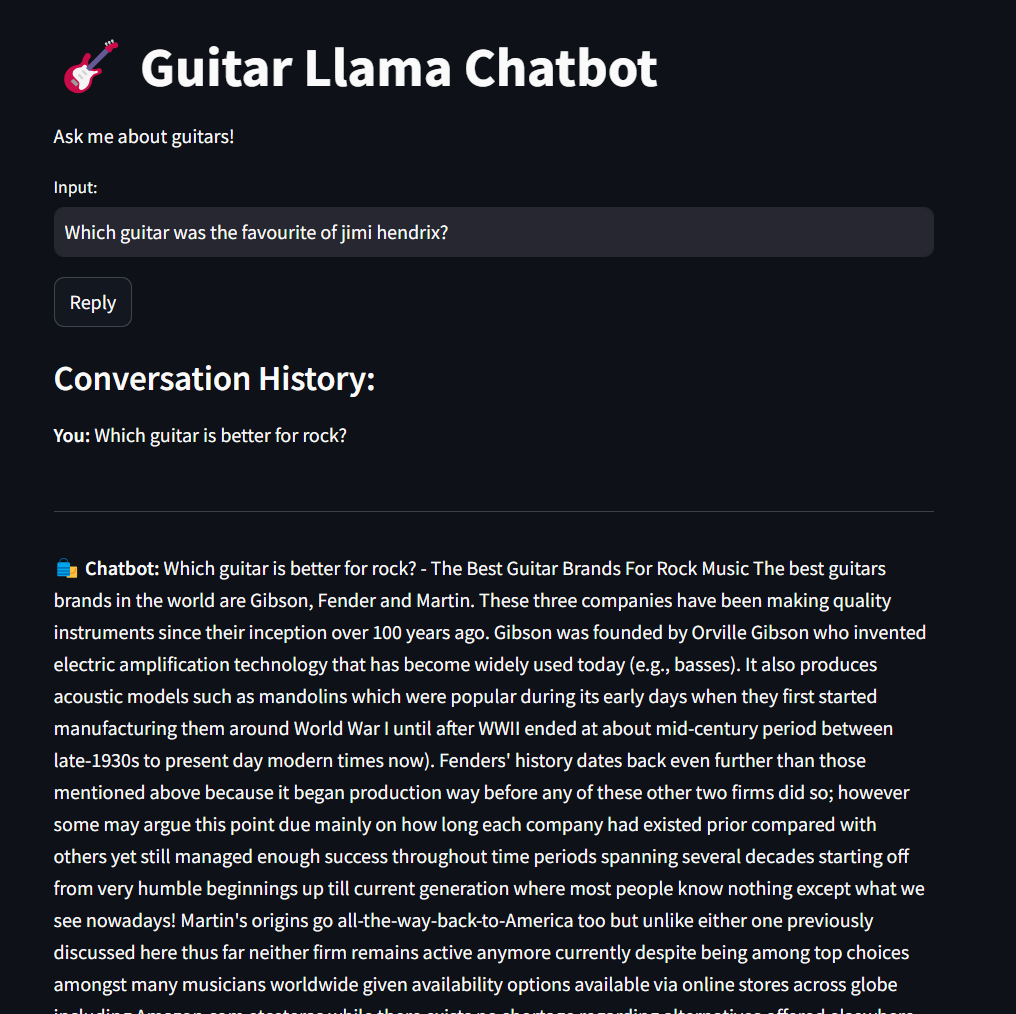

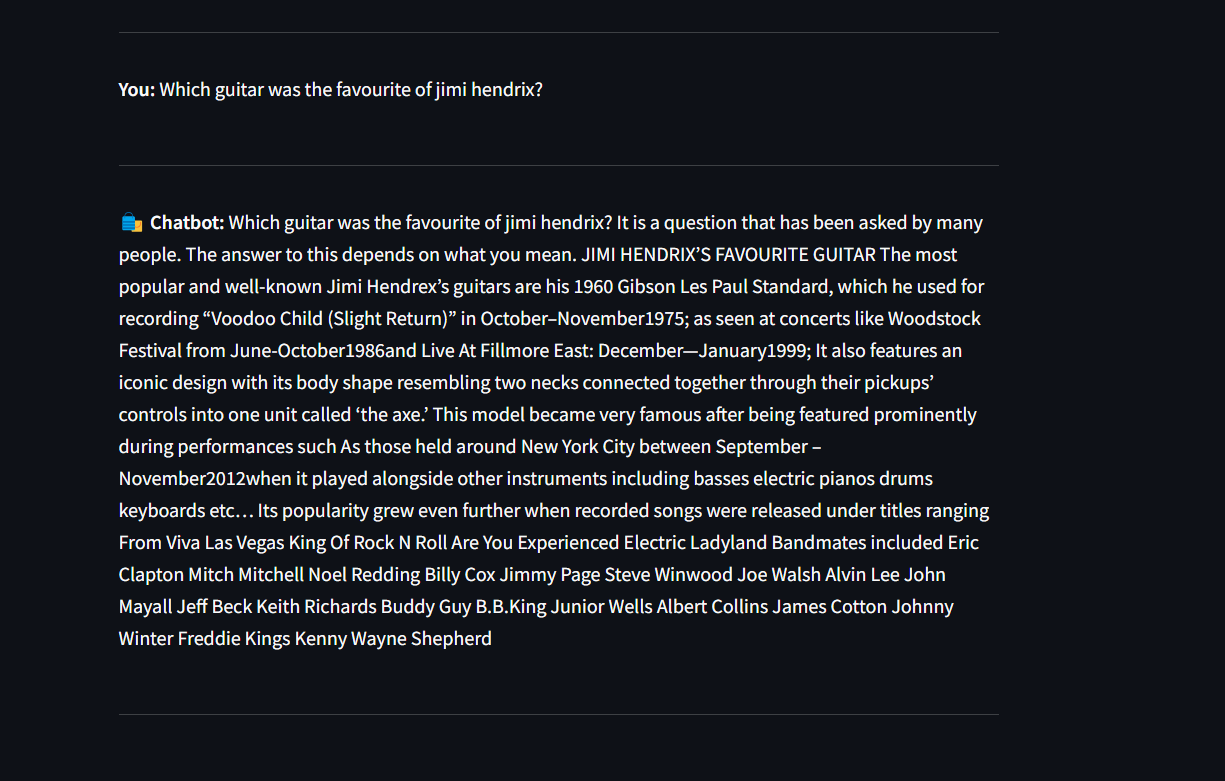

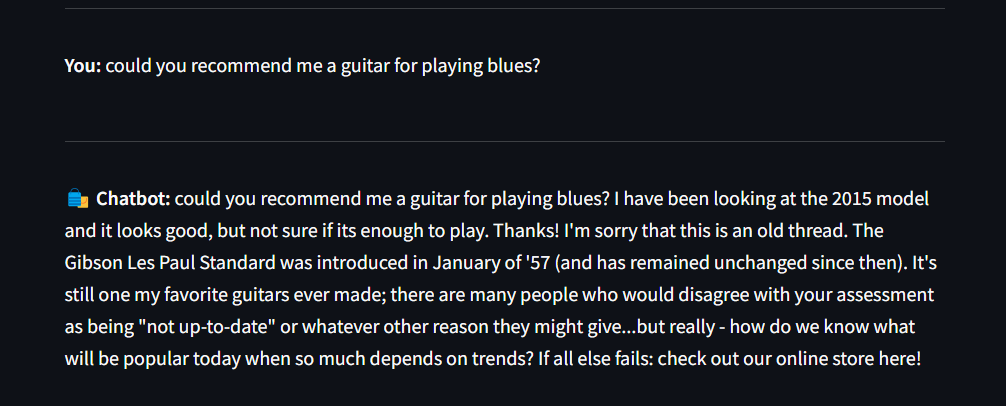



## Conclusiones y resultados

En general, creo que el resultado es bastante bueno teniendo en cuenta que es un modelo bastante pequeño y que el entorno de ejecución es bastante limitado en cuanto a computación.

Pero aun así, el modelo responde con bastante sentido, se aprecia perfectamente el trabajod del fine-tuning ya que el tipo de respuestas están muy estructuradas según el prompt de sistema indicado.

Además nos brinda datos muy específicos que encontramos en el CSV.

Como futuras mejoras, creo que se podría mejorar el prompt de sistema para obtener respuestas más genéricas, ampliar la base de datos y jugar con los hiperparámetros para mejorar los resultados.